In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import riskfolio as rp
import quandl
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats as stats
import math
from scipy.stats import t
import seaborn as sns


import warnings 
warnings.filterwarnings("ignore")


In [3]:
# Define portfolio assets and options
equities_etfs = ['AAPL', 'APTV', 'BAC', 'EEM', 'GOOGL', 'MU', 'JPM', 'MVST', 'PFE', 'SNY', 'STRL', 'SU' , 'UL' , 'VTI' , 'XLF']
options_shorted = [('GOOGL', '2023-04-21', 'C', -2), ('MU', '2023-04-21', 'C', -4), ('AAPL', '2023-04-21', 'P', 2)]

#Download historical stock prices
start_date = '2023-01-01'
end_date = '2023-04-14'
Equity_df = yf.download(equities_etfs, start=start_date, end=end_date)['Adj Close']
portfolio_returns = pd.DataFrame()

[*********************100%***********************]  15 of 15 completed


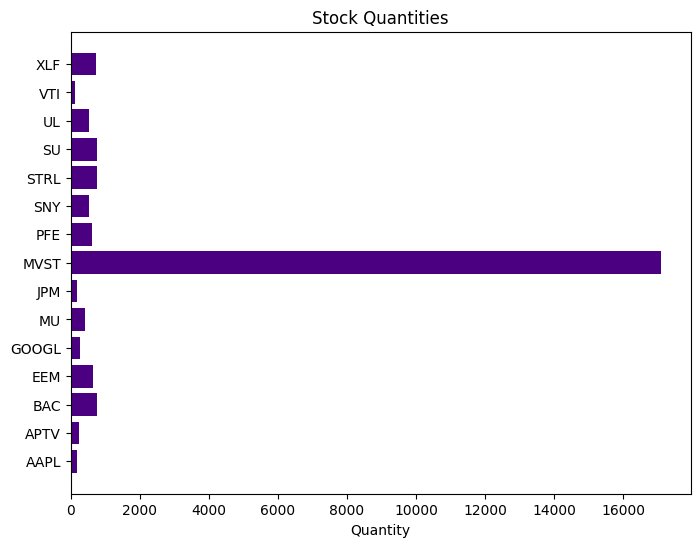

In [4]:
import matplotlib.pyplot as plt

stocks_qty = {'AAPL': 185.0, 'APTV': 239.0, 'BAC': 748.0, 'EEM': 637.0, 'GOOGL': 272.0, 'MU': 427.0, 'JPM': 189.0, 'MVST': 17096.0, 'PFE': 608.0, 'SNY': 542.0, 'STRL': 773.0, 'SU': 775.0, 'UL': 526.0, 'VTI': 131.0, 'XLF': 731.0}

# Get the stocks and quantities as separate lists
stocks = list(stocks_qty.keys())
quantities = list(stocks_qty.values())

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(8,6))
ax.barh(stocks, quantities , color = '#4B0082')

# Set chart title and axis labels
ax.set_title('Stock Quantities')
ax.set_xlabel('Quantity')

plt.show()


In [5]:
# Calculating the daily log return
Equity_df_log_return = np.log1p(Equity_df.pct_change())
Equity_df_log_return

,AAPL,APTV,BAC,EEM,GOOGL,JPM,MU,MVST,PFE,SNY,STRL,SU,UL,VTI,XLF
Date,,,,,,,,,,,,,,,
2023-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-04,0.010261,0.031036,0.018626,0.029645,-0.011738,0.009282,0.073285,0.026145,-0.022291,-0.005320,-0.002694,-0.012994,0.006714,0.008836,0.015899
2023-01-05,-0.010661,-0.000209,-0.002052,-0.003053,-0.021575,-0.000222,0.009366,-0.032790,-0.009420,-0.020521,-0.053884,0.015638,-0.014471,-0.011782,-0.007484
2023-01-06,0.036133,0.025237,0.009930,0.020676,0.013138,0.018955,0.036962,0.032790,0.025056,0.008134,0.011637,0.035034,0.014275,0.021830,0.022004
2023-01-09,0.004081,-0.003362,-0.015227,0.007459,0.007756,-0.004141,-0.007248,0.037979,-0.050963,0.007657,0.006545,0.005087,0.002948,0.000412,-0.003681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-06,0.005481,-0.014264,0.007210,0.004070,0.037113,-0.001098,0.028669,-0.024293,-0.001204,0.019681,-0.009482,-0.012262,0.004864,0.003303,0.003758
2023-04-10,-0.016101,0.012732,0.003586,0.001015,-0.018431,0.003289,0.077359,0.071176,0.005527,-0.016950,0.013762,0.007564,0.000000,0.002261,0.002186
2023-04-11,-0.007620,0.006020,0.027186,0.006068,-0.010293,0.004914,0.004730,0.059277,0.001437,0.004174,0.007659,0.014339,-0.004864,0.001031,0.008696


In [6]:
# Calculating the mean of all returns

mean_log_return = Equity_df_log_return.mean(axis=0)
mean_log_return

AAPL     0.004087
APTV     0.001909
BAC     -0.002223
EEM      0.000634
GOOGL    0.002708
JPM     -0.000453
MU       0.003272
MVST    -0.001731
PFE     -0.002939
SNY      0.001961
STRL     0.001093
SU       0.001288
UL       0.001139
VTI      0.001174
XLF     -0.000691
dtype: float64

In [7]:
#Options Data for Leverage Factor :
Options_data = pd.DataFrame({
    'Date': ['2023-04-13', '2023-04-14'],
    'GOOGL Close': [5.2, 5.8],
    'MU Close': [4.7, 4.3],
    'AAPL Close':[3.2 , 3.0]
})
# set the Date column as the index
Options_data.set_index('Date', inplace=True)

#Stocks Data to calculate Leverage Factor :
#Underlying Data for Leverage Factor :
Underlying_data = pd.DataFrame({
    'Date': ['2023-04-13', '2023-04-14'],
    'GOOGL Close': [107.43, 108.87],
    'MU Close': [63, 62.63],
    'AAPL Close':[165.56 , 165.21]
})
# set the Date column as the index
Underlying_data.set_index('Date', inplace=True)

# Calculate the Leverage Factor

delta = Options_data.diff().iloc[1] / Underlying_data.diff().iloc[1]
leverage_factor= (delta * Underlying_data.iloc[0]) / Options_data.iloc[0]
print(leverage_factor)

GOOGL Close     8.608173
MU Close       14.491087
AAPL Close     29.564286
dtype: float64


In [8]:
mean_log_return_options = pd.Series()
mean_log_return_options['GOOGL_O'] = mean_log_return['GOOGL']
mean_log_return_options['MU_O'] = mean_log_return['MU']
mean_log_return_options['AAPL_O'] = mean_log_return['AAPL']
print(mean_log_return_options)

GOOGL_O    0.002708
MU_O       0.003272
AAPL_O     0.004087
dtype: float64


In [9]:
# Downloading the bonds data
bond_1 = pd.read_csv('Bond1.csv')
bond_2 = pd.read_csv('Bond2.csv')

In [10]:
# Rearranging the data according the dates

bond_1.sort_values(by = 'Date', inplace=True)
bond_2.sort_values(by = 'Date', inplace=True)

In [11]:
# Joining the 2 bonds data into 1

bond_data = pd.DataFrame()
bond_data['Date'] = Equity_df.index
bond_data['Bond1'] = bond_1['Close']
bond_data['Bond2'] = bond_2['Close']

bond_data.set_index('Date', inplace=True)
bond_data.tail()

,Bond1,Bond2
Date,,
2023-04-06,96.44372,95.56055
2023-04-10,96.45293,95.56445
2023-04-11,96.45716,95.49000
2023-04-12,96.48045,96.02734
2023-04-13,96.52075,96.27930


In [12]:
# Calculate the yield of the bonds / Risk Factor

t = 0.1923
T = 1

bond_yield = (-1 / (T-t)) * np.log(bond_data)
bond_yield.head()

,Bond1,Bond2
Date,,
2023-01-03,-5.660842,-5.674099
2023-01-04,-5.661017,-5.674380
2023-01-05,-5.660564,-5.672198
2023-01-06,-5.660870,-5.673821
2023-01-09,-5.660873,-5.672306


In [13]:
#Risk Factor Changes:
risk_factor_bond = bond_yield.diff()
risk_factor_bond

,Bond1,Bond2
Date,,
2023-01-03,NaN,NaN
2023-01-04,-0.000175,-0.000281
2023-01-05,0.000452,0.002182
2023-01-06,-0.000306,-0.001624
2023-01-09,-0.000003,0.001515
...,...,...
2023-04-06,-0.000584,-0.001165
2023-04-10,-0.000118,-0.000051
2023-04-11,-0.000054,0.000965


In [14]:
#Mean for Risk Factor bond changes:
mean_risk_factor_bonds = risk_factor_bond.mean(axis=0)
mean_risk_factor_bonds

Bond1    0.000045
Bond2    0.000282
dtype: float64

In [15]:
# Grouping all the investments together/risk_factor_changes

risk_factor_changes = Equity_df_log_return.copy()
risk_factor_changes['GOOGL_O'] = Equity_df_log_return['GOOGL']
risk_factor_changes['MU_O'] = Equity_df_log_return['MU']
risk_factor_changes['AAPL_O'] = Equity_df_log_return['AAPL']
risk_factor_changes['Bond_1'] = risk_factor_bond['Bond1']
risk_factor_changes['Bond_2'] =  risk_factor_bond['Bond2']
risk_factor_changes = risk_factor_changes[1:]

risk_factor_changes

,AAPL,APTV,BAC,EEM,GOOGL,JPM,MU,MVST,PFE,SNY,STRL,SU,UL,VTI,XLF,GOOGL_O,MU_O,AAPL_O,Bond_1,Bond_2
Date,,,,,,,,,,,,,,,,,,,,
2023-01-04,0.010261,0.031036,0.018626,0.029645,-0.011738,0.009282,0.073285,0.026145,-0.022291,-0.005320,-0.002694,-0.012994,0.006714,0.008836,0.015899,-0.011738,0.073285,0.010261,-0.000175,-0.000281
2023-01-05,-0.010661,-0.000209,-0.002052,-0.003053,-0.021575,-0.000222,0.009366,-0.032790,-0.009420,-0.020521,-0.053884,0.015638,-0.014471,-0.011782,-0.007484,-0.021575,0.009366,-0.010661,0.000452,0.002182
2023-01-06,0.036133,0.025237,0.009930,0.020676,0.013138,0.018955,0.036962,0.032790,0.025056,0.008134,0.011637,0.035034,0.014275,0.021830,0.022004,0.013138,0.036962,0.036133,-0.000306,-0.001624
2023-01-09,0.004081,-0.003362,-0.015227,0.007459,0.007756,-0.004141,-0.007248,0.037979,-0.050963,0.007657,0.006545,0.005087,0.002948,0.000412,-0.003681,0.007756,-0.007248,0.004081,-0.000003,0.001515
2023-01-10,0.004447,0.016800,0.006764,0.007158,0.004534,0.008914,0.014969,0.054394,-0.016040,0.006370,0.022425,-0.015663,0.001177,0.007851,0.005658,0.004534,0.014969,0.004447,0.000495,0.001980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-06,0.005481,-0.014264,0.007210,0.004070,0.037113,-0.001098,0.028669,-0.024293,-0.001204,0.019681,-0.009482,-0.012262,0.004864,0.003303,0.003758,0.037113,0.028669,0.005481,-0.000584,-0.001165
2023-04-10,-0.016101,0.012732,0.003586,0.001015,-0.018431,0.003289,0.077359,0.071176,0.005527,-0.016950,0.013762,0.007564,0.000000,0.002261,0.002186,-0.018431,0.077359,-0.016101,-0.000118,-0.000051
2023-04-11,-0.007620,0.006020,0.027186,0.006068,-0.010293,0.004914,0.004730,0.059277,0.001437,0.004174,0.007659,0.014339,-0.004864,0.001031,0.008696,-0.010293,0.004730,-0.007620,-0.000054,0.000965


In [16]:
# Calculate covariance matrix
covariance_matrix = risk_factor_changes.cov()

# Print covariance matrix
covariance_matrix

,AAPL,APTV,BAC,EEM,GOOGL,JPM,MU,MVST,PFE,SNY,STRL,SU,UL,VTI,XLF,GOOGL_O,MU_O,AAPL_O,Bond_1,Bond_2
AAPL,2.094428e-04,1.352791e-04,0.000099,6.729561e-05,2.343372e-04,0.000087,1.639927e-04,0.000307,5.337156e-05,-0.000006,0.000097,3.850797e-05,2.411053e-05,1.184585e-04,0.000102,2.343372e-04,1.639927e-04,2.094428e-04,-4.931645e-08,5.741178e-06
APTV,1.352791e-04,4.237080e-04,0.000201,1.025423e-04,1.744759e-04,0.000174,2.668493e-04,0.000353,2.139144e-05,0.000020,0.000224,1.207418e-04,2.519764e-05,1.519864e-04,0.000173,1.744759e-04,2.668493e-04,1.352791e-04,7.195081e-07,-1.737682e-07
BAC,9.900528e-05,2.014643e-04,0.000347,6.274546e-05,1.101682e-04,0.000237,1.725646e-04,0.000182,5.896995e-05,0.000005,0.000196,1.408825e-04,2.223375e-05,1.275653e-04,0.000222,1.101682e-04,1.725646e-04,9.900528e-05,2.511463e-06,1.185438e-05
EEM,6.729561e-05,1.025423e-04,0.000063,1.074215e-04,7.964619e-05,0.000062,1.510737e-04,0.000121,1.306854e-05,0.000039,0.000043,6.942656e-05,3.482496e-05,6.654097e-05,0.000067,7.964619e-05,1.510737e-04,6.729561e-05,-4.050910e-07,-1.974749e-06
GOOGL,2.343372e-04,1.744759e-04,0.000110,7.964619e-05,5.733946e-04,0.000067,2.285083e-04,0.000415,5.626974e-05,0.000012,0.000125,4.711129e-06,9.323970e-07,1.645290e-04,0.000112,5.733946e-04,2.285083e-04,2.343372e-04,1.038662e-06,1.684809e-05
JPM,8.722229e-05,1.737305e-04,0.000237,6.191979e-05,6.650564e-05,0.000267,1.201722e-04,0.000182,5.181425e-05,0.000027,0.000174,1.630518e-04,4.781660e-05,1.036225e-04,0.000183,6.650564e-05,1.201722e-04,8.722229e-05,2.184688e-06,8.947605e-06
MU,1.639927e-04,2.668493e-04,0.000173,1.510737e-04,2.285083e-04,0.000120,7.080994e-04,0.000253,3.055139e-05,0.000016,0.000098,9.286994e-05,8.619781e-06,1.471656e-04,0.000149,2.285083e-04,7.080994e-04,1.639927e-04,-7.307069e-07,-4.002636e-06
MVST,3.072593e-04,3.526696e-04,0.000182,1.214532e-04,4.146018e-04,0.000182,2.528285e-04,0.001706,1.206253e-04,-0.000070,0.000233,1.254695e-05,4.353743e-05,2.355809e-04,0.000192,4.146018e-04,2.528285e-04,3.072593e-04,4.551266e-06,3.624867e-05
PFE,5.337156e-05,2.139144e-05,0.000059,1.306854e-05,5.626974e-05,0.000052,3.055139e-05,0.000121,1.577642e-04,0.000018,0.000051,3.012400e-05,3.555943e-05,5.131453e-05,0.000050,5.626974e-05,3.055139e-05,5.337156e-05,9.167313e-07,3.721837e-06
SNY,-5.991668e-06,1.972232e-05,0.000005,3.948529e-05,1.245841e-05,0.000027,1.590268e-05,-0.000070,1.828593e-05,0.000170,0.000028,3.162592e-05,3.652075e-05,2.428210e-05,0.000030,1.245841e-05,1.590268e-05,-5.991668e-06,-1.248629e-06,-1.161561e-05


In [17]:
#Loss Distribution Of Equity :
# Stock quantities
stocks_qty = {'AAPL': 185.0, 'APTV': 239.0, 'BAC': 748.0, 'EEM': 637.0, 'GOOGL': 272.0, 'MU': 427.0, 'JPM': 189.0, 'MVST': 17096.0, 'PFE': 608.0, 'SNY': 542.0, 'STRL': 773.0, 'SU': 775.0, 'UL': 526.0, 'VTI': 131.0, 'XLF': 731.0}

# Stock prices
stock_prices = [165.559998, 106.040001, 28.559999, 39.930000, 107.430000, 128.990005, 63.000000, 1.34, 41.470001, 56.099998, 36.070000, 32.650002, 54.110001, 205.649994, 32.560001]

# Calculate the loss distribution for each stock
loss_distribution = {}
for stock, qty in stocks_qty.items():
    stock_price = stock_prices.pop(0)
    loss = qty * stock_price
    loss_distribution[stock] = loss

# Print the loss distribution for each stock
print("Loss Distribution for Each Stock:")
for stock, loss in loss_distribution.items():
    print(f"{stock}: {loss}")


Loss Distribution for Each Stock:
AAPL: 30628.59963
APTV: 25343.560239000002
BAC: 21362.879252000002
EEM: 25435.41
GOOGL: 29220.960000000003
MU: 55078.732135
JPM: 11907.0
MVST: 22908.640000000003
PFE: 25213.760608
SNY: 30406.198916
STRL: 27882.11
SU: 25303.75155
UL: 28461.860525999997
VTI: 26940.149213999997
XLF: 23801.360731


In [18]:
#Loss Distribution for Options :
# GOOGL :

# Price of underlying asset
Number_of_Options_GOOGL = 200
Price_of_Underlying_GOOGL = 7.2
# Loss factor for options
loss_factor_option_GOOGL = 40.085821

# Calculate the loss distribution for options
loss_distribution_options_GOOGL = Number_of_Options_GOOGL * Price_of_Underlying_GOOGL * loss_factor_option_GOOGL
print("Loss Distribution of GOOGL option :", loss_distribution_options_GOOGL)


# MU

# Price of underlying asset
Number_of_Options_MU = 400
Price_of_Underlying_MU = 3.9
# Loss factor for options
loss_factor_option_MU = 68.762994

# Calculate the loss distribution for options
loss_distribution_options_MU = Number_of_Options_MU * Price_of_Underlying_MU * loss_factor_option_MU
print("Loss Distribution of MU option :", loss_distribution_options_MU)

#AAPL

# Price of underlying asset
Number_of_Options_AAPL = 200
Price_of_Underlying_AAPL = 2.9
# Loss factor for options
loss_factor_option_AAPL = 236.514286

# Calculate the loss distribution for options
loss_distribution_options_AAPL = Number_of_Options_AAPL * Price_of_Underlying_AAPL * loss_factor_option_AAPL
print("Loss Distribution of APPL option :", loss_distribution_options_AAPL)

Loss Distribution of GOOGL option : 57723.58224
Loss Distribution of MU option : 107270.27064
Loss Distribution of APPL option : 137178.28588


In [19]:
#Loss Distribution of Bonds :
#Bond1:
Num_Bond1 = 3084
Bond1_Price = 97.29100
Time_maturity_Bond1 = 0.6
Loss_Dis_Bond1 =  Num_Bond1*Bond1_Price*Time_maturity_Bond1
print("Loss Distribution of Bond1 :", Loss_Dis_Bond1)

#Bond1:
Num_Bond2 = 3332
Bond2_Price = 96.021532
Time_maturity_Bond2 = 0.6
Loss_Dis_Bond2 =  Num_Bond2*Bond2_Price*Time_maturity_Bond2
print("Loss Distribution of Bond2 :", Loss_Dis_Bond2)

Loss Distribution of Bond1 : 180027.2664
Loss Distribution of Bond2 : 191966.24677439997


In [20]:
#This is a C Vector:
## Create a list to store the loss distributions
portfolio_loss_distribution = []

# Append the loss distributions for stocks to the list
for stock, loss in loss_distribution.items():
    portfolio_loss_distribution.append(loss)

# Append the loss distributions for options to the list
portfolio_loss_distribution.append(loss_distribution_options_GOOGL)
portfolio_loss_distribution.append(loss_distribution_options_MU)
portfolio_loss_distribution.append(loss_distribution_options_AAPL)

# Append the loss distributions for bonds to the list
portfolio_loss_distribution.append(Loss_Dis_Bond1)
portfolio_loss_distribution.append(Loss_Dis_Bond2)

portfolio_loss_distribution

[30628.59963,
 25343.560239000002,
 21362.879252000002,
 25435.41,
 29220.960000000003,
 55078.732135,
 11907.0,
 22908.640000000003,
 25213.760608,
 30406.198916,
 27882.11,
 25303.75155,
 28461.860525999997,
 26940.149213999997,
 23801.360731,
 57723.58224,
 107270.27064,
 137178.28588,
 180027.2664,
 191966.24677439997]

In [21]:
portfolio_loss_distribution

[30628.59963,
 25343.560239000002,
 21362.879252000002,
 25435.41,
 29220.960000000003,
 55078.732135,
 11907.0,
 22908.640000000003,
 25213.760608,
 30406.198916,
 27882.11,
 25303.75155,
 28461.860525999997,
 26940.149213999997,
 23801.360731,
 57723.58224,
 107270.27064,
 137178.28588,
 180027.2664,
 191966.24677439997]

In [22]:
#To find the Portfolio's Mean :
mean_log_return

AAPL     0.004087
APTV     0.001909
BAC     -0.002223
EEM      0.000634
GOOGL    0.002708
JPM     -0.000453
MU       0.003272
MVST    -0.001731
PFE     -0.002939
SNY      0.001961
STRL     0.001093
SU       0.001288
UL       0.001139
VTI      0.001174
XLF     -0.000691
dtype: float64

In [23]:
#Mean of risk factor changes:
mean_risk_factor_investment = mean_log_return.append(mean_log_return_options)
mean_risk_factor_investment = mean_risk_factor_investment.append(mean_risk_factor_bonds)
print(mean_risk_factor_investment)

AAPL       0.004087
APTV       0.001909
BAC       -0.002223
EEM        0.000634
GOOGL      0.002708
JPM       -0.000453
MU         0.003272
MVST      -0.001731
PFE       -0.002939
SNY        0.001961
STRL       0.001093
SU         0.001288
UL         0.001139
VTI        0.001174
XLF       -0.000691
GOOGL_O    0.002708
MU_O       0.003272
AAPL_O     0.004087
Bond1      0.000045
Bond2      0.000282
dtype: float64


In [24]:
#Portfolio Mean:
portfolio_mean = np.dot(portfolio_loss_distribution, mean_risk_factor_investment)
portfolio_mean 

1422.0034390162116

In [25]:
#Varriance of Portfolio:
portfolio_varriance = np.dot(portfolio_loss_distribution ,covariance_matrix)
portfolio_varriance = np.dot(portfolio_varriance.T , portfolio_loss_distribution )
portfolio_varriance

80032625.37748629

In [26]:
#Std deviation : 
Std_deviation = portfolio_varriance**0.5
Std_deviation

8946.095538137646

#### For normal distribution

In [27]:
import numpy as np
from scipy.stats import norm

# Horizon and confidence level
h = 120 # horizon of 120 days
alpha1 = 0.05 # 95% confidence level
alpha2 = 0.03 # 97% confidence level
# Calculate volatility over the horizon
sig_h = Std_deviation 

# Calculate VaR for the portfolio for 0.95
VaR_n_1 = norm.ppf(1 - alpha1) * sig_h + portfolio_mean

# Calculate VaR for the portfolio for 0.97
VaR_n_2 = norm.ppf(1 - alpha2) * sig_h + portfolio_mean

print("95% VaR normal is", round(VaR_n_1, 2))
print("97% VaR normal is", round(VaR_n_2, 2))

95% VaR normal is 16137.02
97% VaR normal is 18247.76


In [28]:
# import numpy as np
from scipy.stats import norm

# Horizon and confidence levels
h = 120 # horizon of 120 days
alpha1 = 0.95 # 95% confidence level
alpha2 = 0.97 # 97% confidence level

# Calculate volatility over the horizon
sig_h = Std_deviation 

# Calculate Expected Shortfall (CVaR) for 95% confidence level
ES_n1 = (1 / (1 - alpha1)) * (norm.pdf(norm.ppf(alpha1)) * sig_h) + portfolio_mean

# Calculate Expected Shortfall (CVaR) for 97% confidence level
ES_n2 = (1 / (1 - alpha2)) * (norm.pdf(norm.ppf(alpha2)) * sig_h) + portfolio_mean

print("95% CVaR/ES normal is", round(ES_n1, 2))
print("97% CVaR/ES normal is", round(ES_n2, 2))

95% CVaR/ES normal is 19875.23
97% CVaR/ES normal is 21712.33


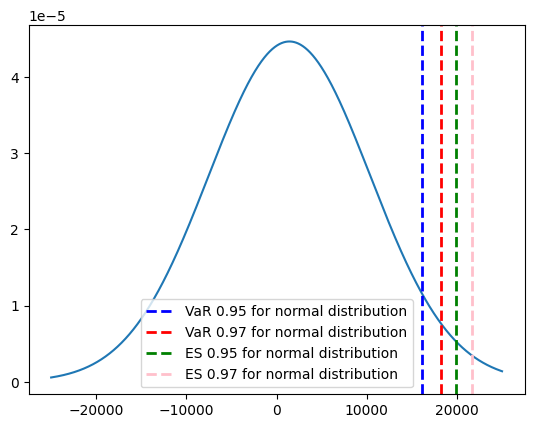

In [29]:
from scipy.stats import norm
x_axis  = np.arange(-25000,25000, 0.01)
plt.plot(x_axis, norm.pdf(x_axis, portfolio_mean,Std_deviation))
plt.axvline(x=VaR_n_1, color='blue', linestyle='dashed', linewidth=2, label='VaR 0.95 for normal distribution' )
plt.axvline(x=VaR_n_2, color='red', linestyle='dashed', linewidth=2, label='VaR 0.97 for normal distribution' )
plt.axvline(x=ES_n1, color='green', linestyle='dashed', linewidth=2, label='ES 0.95 for normal distribution' )
plt.axvline(x=ES_n2, color='pink', linestyle='dashed', linewidth=2, label='ES 0.97 for normal distribution' )
plt.legend()
plt.show()

#### For t-distribution

In [39]:
# Horizon and confidence levels
import math
from scipy.stats import t

# Input variables
mean =  portfolio_mean  # Portfolio mean
std_dev = Std_deviation # Portfolio standard deviation
conf_level_1 = 0.95   # 95% confidence level
conf_level_2 = 0.97
sample_size = 20   # Portfolio sample size
#df = 5
# Calculate t-statistic
df = sample_size - 1 if sample_size < 30 else math.inf
t_stat_1 = t.ppf(conf_level_1, df)
t_stat_2 = t.ppf(conf_level_2, df)

# Calculate VaR
var_t_1 = (t_stat_1 * std_dev) + mean

var_t_2 = (t_stat_2 * std_dev) + mean

print("95% CVaR/ES t-distribution is", round(var_t_1, 2))
print("97% CVaR/ES t-distribution is", round(var_t_2, 2))


95% CVaR/ES t-distribution is 16890.99
97% CVaR/ES t-distribution is 19314.35


In [43]:
# Horizon and confidence levels
import math
from scipy.stats import t
 
# Horizon and confidence levels
h = 120 # horizon of 120 days
alpha1 = 0.95 # 95% confidence level
alpha2 = 0.97 # 97% confidence level
portfolio_size = 20
# Calculate degrees of freedom for t-distribution
n = portfolio_size - 1
#n = 5

# Calculate volatility over the horizon
sig_h_t = Std_deviation 

# Calculate Expected Shortfall (CVaR) for 95% confidence level
ES_t_1 = ((t.pdf(t.ppf(alpha1, n), n) / (1 - alpha1)) * sig_h_t) + portfolio_mean

# Calculate Expected Shortfall (CVaR) for 97% confidence level
ES_t_2 =  ((t.pdf(t.ppf(alpha2, n), n) / (1 - alpha2)) * sig_h_t) + portfolio_mean 

print("95% CVaR/ES t-distribution is", round(ES_t_1, 2))
print("97% CVaR/ES t-distribution is", round(ES_t_2, 2))

95% CVaR/ES t-distribution is 17758.74
97% CVaR/ES t-distribution is 18798.21


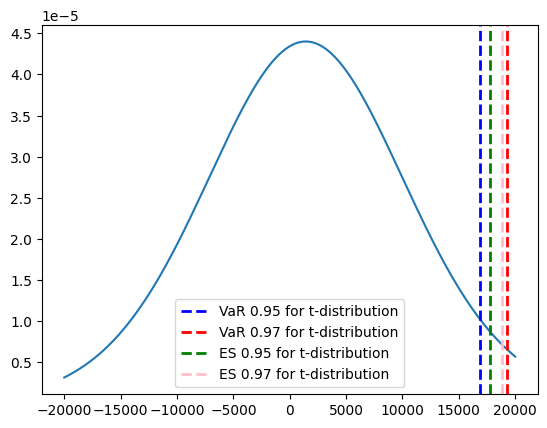

In [44]:
from scipy.stats import t
x_axis = np.arange(-20000, 20000, 0.01)
plt.plot(x_axis, t.pdf(x_axis, sample_size-1 , portfolio_mean, Std_deviation))
plt.axvline(x=var_t_1, color='blue', linestyle='dashed', linewidth=2, label='VaR 0.95 for t-distribution')
plt.axvline(x=var_t_2, color='red', linestyle='dashed', linewidth=2, label='VaR 0.97 for t-distribution')
plt.axvline(x=ES_t_1, color='green', linestyle='dashed', linewidth=2, label='ES 0.95 for t-distribution')
plt.axvline(x=ES_t_2, color='pink', linestyle='dashed', linewidth=2, label='ES 0.97 for t-distribution')
plt.legend()
plt.show()

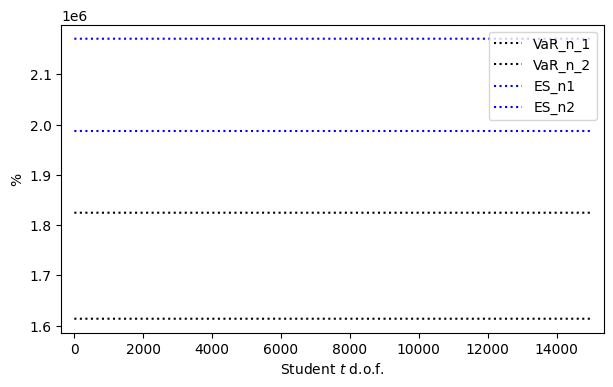

In [32]:
# Plot VaR and CVaR for the normal and t-distributions
fig, ax = plt.subplots(figsize=(7,4))
plt.plot(np.arange(0,15000), VaR_n_1*np.ones(15000)*100, ":k", label="VaR_n_1")
plt.plot(np.arange(0,15000), VaR_n_2*np.ones(15000)*100, ":k", label="VaR_n_2")
plt.plot(np.arange(0,15000), ES_n1*np.ones(15000)*100, ":b", label="ES_n1")
plt.plot(np.arange(0,15000), ES_n2*np.ones(15000)*100, ":b",label="ES_n2" )
plt.xlabel("Student $t$ d.o.f.")
plt.ylabel("%")
plt.legend(loc=1)
ax.margins(x=0.025, y=0.05) # add extra padding
plt.show()

### Linearized Distibution for Everyday of our portfolio:

In [33]:
#linearized loss for Equity:
linearized_loss_equity = []
Dict = {'AAPL': 185.0, 'APTV': 239.0, 'BAC': 748.0, 'EEM': 637.0, 'GOOGL': 272.0, 'MU': 427.0, 'JPM': 189.0, 'MVST': 17096.0, 'PFE': 608.0, 'SNY': 542.0, 'STRL': 773.0, 'SU': 775.0, 'UL': 526.0, 'VTI': 131.0, 'XLF': 731.0}
stocks_qty = pd.Series(Dict)
for i in range(len(risk_factor_changes)):
    S_t1 = Equity_df.iloc[i+1]
    S_t = Equity_df.iloc[i]
    X_t1 = np.log(S_t1 / S_t)
    linearized_loss_equity.append((stocks_qty * S_t * X_t1).sum())
linearized_loss_equity

[3901.8953727861967,
 -4284.531189442908,
 8197.925527833719,
 -357.8849581397616,
 3304.1453184677202,
 3853.021717638727,
 2204.594811865827,
 2484.217322648092,
 -3633.3237832589525,
 -4804.390754514976,
 -2325.158488638058,
 6123.795734464293,
 6106.631879864627,
 -399.36850688986453,
 -749.3440273884966,
 2834.290696208706,
 1618.2633978699087,
 -3729.0580333178054,
 5838.002097212634,
 2509.2857999344255,
 4157.133101473804,
 -2067.5746727755245,
 -4452.485294655067,
 5356.7578541873345,
 -4702.595378803838,
 -5247.7600772698115,
 -384.9844777990012,
 3061.9213165189985,
 2432.3787206698316,
 4039.1624009385955,
 -7879.161021369809,
 -1602.6996773811172,
 -8530.060007659258,
 -1445.2700643508874,
 1856.01264509494,
 -2409.255880002395,
 848.1020382146115,
 -1449.7536545145326,
 1310.4868470596011,
 1663.079395194466,
 5646.454446599173,
 -324.0086283452826,
 -6447.960964749123,
 398.42635509333525,
 -10522.449826064165,
 -4353.885774419685,
 -3147.0041816208595,
 5489.37342182985

In [34]:
# Linearized Loss for Options
# lambai * st+1 * xt+1 * leverage
linearized_loss_options = []
option_list = ['GOOGL', 'MU', 'AAPL']
number_option = [-200,-400,200]
data_option = Equity_df[option_list]
leverage_factor_option = pd.Series(leverage_factor.values, index=option_list)
for i in range(len(risk_factor_changes)):
    S_t1 = data_option.iloc[i+1]
    S_t = data_option.iloc[i]
    X_t1 = np.log(S_t1 / S_t)
    linearized_loss_options.append((number_option * S_t * X_t1 * leverage_factor_option).sum())
linearized_loss_options

[-11975.637235328533,
 -7618.16103038137,
 13022.514969738133,
 4336.834702384122,
 -2150.791462784441,
 5998.516980453733,
 4801.733687121572,
 8207.501644876724,
 8834.806499360026,
 -2055.7263440499573,
 -2065.0591904816715,
 -5058.675170564005,
 -3011.57963146556,
 15232.200475447666,
 -1256.1673296272238,
 1179.3969276144944,
 2258.8618115977097,
 -527.4174563018314,
 12593.435726269749,
 -9069.140356103468,
 15815.727594643096,
 31055.647972175244,
 1101.9584414360543,
 -3122.2701996024552,
 9596.4592346107,
 1860.5842098500589,
 5033.101606461293,
 14836.702370166533,
 -15073.201337872782,
 9995.429592512364,
 3358.701085918028,
 1193.22316160033,
 -11668.44765515527,
 6386.107806669279,
 -5876.818644619469,
 -9677.231347391733,
 7480.037300120604,
 -2884.3747002156133,
 -10233.709890313461,
 6048.62058900573,
 24920.825670542094,
 13587.194674948038,
 -3650.9857916320325,
 -795.1203538285345,
 -2677.3719695825203,
 -5608.565114997467,
 16762.379425760744,
 5466.541234085314,
 -

In [35]:
Bond_Names=['Bond1','Bond2']
linearized_loss_bonds = []
Num_Bond = pd.Series([3084, 3332], index= Bond_Names)
Bond_Price = pd.Series([97.29100, 96.021532], index= Bond_Names)
Time_maturity_Bond = pd.Series([252, 766], index= Bond_Names)
#Risk_factor_changes = pd.concat([Bond1_RFC,Bond2_RFC], axis=1)

for i in range(len(risk_factor_changes)):
    linearized_loss_bonds.append((Num_Bond * Bond_Price * (i/Time_maturity_Bond - 1) * risk_factor_bond.iloc[i]).sum())
linearized_loss_bonds

[0.0,
 141.9765203046832,
 -830.9053241577994,
 608.1509112948418,
 -481.39579412489337,
 -774.8742070319746,
 -393.53255609202824,
 -861.2831722029697,
 -468.3695080823967,
 1702.6754071443013,
 -2041.9912530280822,
 1025.5120080563233,
 -992.4605035517951,
 -426.8353137849587,
 -246.44925256851747,
 -2731.847706614037,
 -417.0630894002477,
 -874.2513685762142,
 511.0685532004479,
 -881.5225640547599,
 -620.9807086615373,
 -868.8024326201958,
 -1579.299196235987,
 -980.4138830964067,
 -2353.241764432359,
 290.553636901373,
 2936.3952300597402,
 -577.0144388605164,
 -1010.688843792955,
 2356.409493139077,
 213.2732534093761,
 -856.9363774022149,
 -1319.134715072956,
 -797.4687184760917,
 -25.446728450588758,
 505.80572063935307,
 -1873.5184113130626,
 -561.3848063672036,
 819.7634929250082,
 111.99661235788085,
 -1605.7227511862475,
 -959.0775110042401,
 1818.1738809367494,
 -198.81024701316338,
 830.0857878386555,
 1142.7776793390797,
 1611.0147108240976,
 -1353.5524395111638,
 -1083.

In [36]:
linearized_loss_total = []
for i in range(60):
    linearized_loss_total.append(linearized_loss_equity[i] + linearized_loss_options[i] + linearized_loss_bonds[i])
    
linearized_loss_total

[-8073.741862542336,
 -11760.715699519596,
 20389.53517341405,
 4587.100655539201,
 671.9580615583857,
 9076.664491060485,
 6612.795942895371,
 9830.435795321846,
 4733.113208018676,
 -5157.441691420632,
 -6432.208932147811,
 2090.6325719566107,
 2102.591744847272,
 14405.996654772842,
 -2251.960609584238,
 1281.839917209163,
 3460.0621200673704,
 -5130.7268581958515,
 18942.506376682828,
 -7441.377120223802,
 19351.879987455362,
 28119.270866779523,
 -4929.8260494549995,
 1254.0737714884726,
 2540.6220913745033,
 -3096.6222305183796,
 7584.512358722032,
 17321.609247825018,
 -13651.511460995906,
 16391.001486590038,
 -4307.186682042405,
 -1266.412893183002,
 -21517.642377887485,
 4143.3690238423005,
 -4046.252727975117,
 -11580.681506754774,
 6454.6209270221525,
 -4895.51316109735,
 -8103.459550328852,
 7823.696596558077,
 28961.557365955017,
 12304.108535598516,
 -8280.772875444407,
 -595.5042457483626,
 -12369.73600780803,
 -8819.673210078072,
 15226.389954963983,
 9602.362216404006

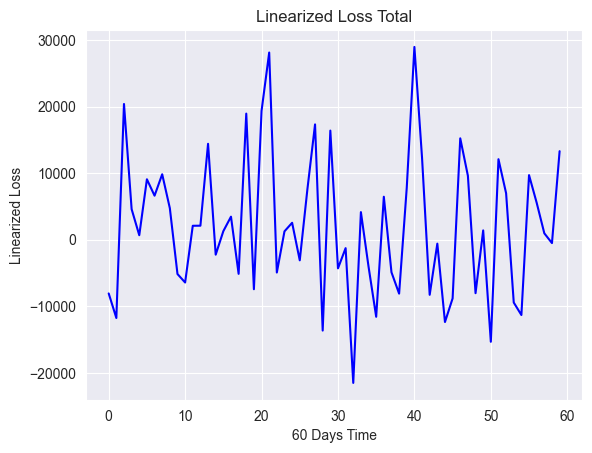

In [37]:
# Set style for seaborn
sns.set_style('darkgrid')
# Create scatter plot
plt.plot(linearized_loss_total, color='blue')
# Add axis labels and title
plt.xlabel('60 Days Time')
plt.ylabel('Linearized Loss')
plt.title('Linearized Loss Total')

# Show the plot
plt.show()
plt.show()

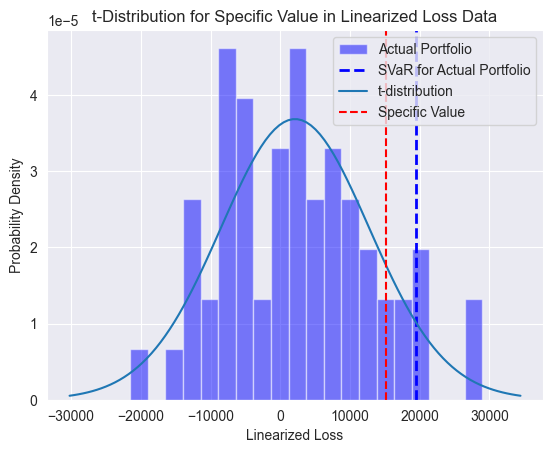

In [56]:
from scipy.stats import t
value = linearized_loss_total[-14]
dof = len(linearized_loss_total) - 1

mean = np.mean(linearized_loss_total)
std = np.std(linearized_loss_total, ddof=1)

t_dist = t.pdf(value, df=dof, loc=mean, scale=std)
plt.hist(linearized_loss_total, bins=20, density=True, alpha=0.5, color='blue', label='Actual Portfolio')
plt.axvline(x=svar_actual, color='blue', linestyle='dashed', linewidth=2, label='SVaR for Actual Portfolio')
x = np.linspace(mean - 3*std, mean + 3*std, 100)
y = t.pdf(x, df=dof, loc=mean, scale=std)

plt.plot(x, y, label='t-distribution')
plt.axvline(x=value, color='r', linestyle='--', label='Specific Value')
plt.xlabel('Linearized Loss')
plt.ylabel('Probability Density')
plt.title('t-Distribution for Specific Value in Linearized Loss Data')
plt.legend()
plt.show()

In [39]:
# Calculate SVaR for your actual portfolio returns
confidence_level = 0.95 # Confidence level for SVaR
window = 52 # Window size for historical simulation (52 weeks in this case)
svar_actual = np.percentile(linearized_loss_total, (confidence_level)*100) # SVaR for actual portfolio

In [40]:
print("SVaR for Actual Portfolio: ", svar_actual)

SVaR for Actual Portfolio:  19403.762746753295


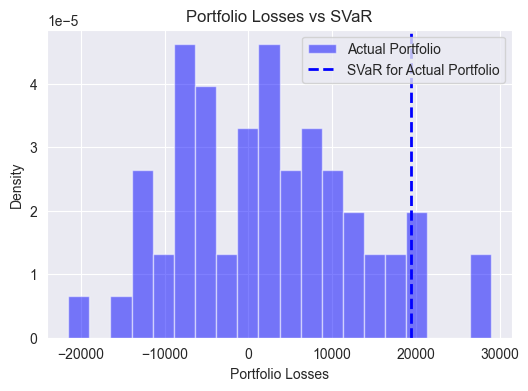

In [41]:
plt.figure(figsize=(6, 4))
# Plot histograms for actual portfolio, scenario 1, and scenario 2
plt.hist(linearized_loss_total, bins=20, density=True, alpha=0.5, color='blue', label='Actual Portfolio')
plt.axvline(x=svar_actual, color='blue', linestyle='dashed', linewidth=2, label='SVaR for Actual Portfolio')
plt.xlabel('Portfolio Losses')
plt.ylabel('Density')
plt.title('Portfolio Losses vs SVaR')
plt.legend()
plt.show()

### Polynomial Tail Modeling :

In [42]:
# Sorting the Linearized Daily Loss

linearized_loss_total_sort = sorted(linearized_loss_total)
n = len(linearized_loss_total)
linearized_loss_total_sort

[-21517.642377887485,
 -15336.493942722145,
 -13651.511460995906,
 -12369.73600780803,
 -11760.715699519596,
 -11580.681506754774,
 -11316.274005509084,
 -9439.592221383928,
 -8819.673210078072,
 -8280.772875444407,
 -8103.459550328852,
 -8073.741862542336,
 -8036.097409356269,
 -7441.377120223802,
 -6432.208932147811,
 -5157.441691420632,
 -5130.7268581958515,
 -4929.8260494549995,
 -4895.51316109735,
 -4307.186682042405,
 -4046.252727975117,
 -3096.6222305183796,
 -2251.960609584238,
 -1266.412893183002,
 -595.5042457483626,
 -510.4798615915147,
 671.9580615583857,
 959.9337542933617,
 1254.0737714884726,
 1281.839917209163,
 1395.5655100227204,
 2090.6325719566107,
 2102.591744847272,
 2540.6220913745033,
 3460.0621200673704,
 4143.3690238423005,
 4587.100655539201,
 4733.113208018676,
 5545.082861936935,
 6454.6209270221525,
 6612.795942895371,
 6975.414869613415,
 7584.512358722032,
 7823.696596558077,
 9076.664491060485,
 9602.362216404006,
 9697.632535517367,
 9830.435795321846,

In [43]:
# Value at Risk norm-distribution

mean = np.mean(linearized_loss_total)
std = np.std(linearized_loss_total)
conf_level = 0.90  


# Calculate VaR for the portfolio for 0.95
VaR_n_90 = norm.ppf(conf_level) * std + mean
print(VaR_n_90)

15812.53733688895


In [44]:
# Taking the Linearized Loss > VaR_0.9

linearized_loss_total_greater = [loss_val for loss_val in linearized_loss_total_sort if loss_val > VaR_n_90]
linearized_loss_total_greater

[16391.001486590038,
 17321.609247825018,
 18942.506376682828,
 19351.879987455362,
 20389.53517341405,
 28119.270866779523,
 28961.557365955017]

In [45]:
# Index of the first statistics greater than the Var_0.9

m = n - len(linearized_loss_total_greater)
m

53

In [46]:
linearized_loss_total_sort[m]

16391.001486590038

In [47]:
# Creating x and y for Linear Regression

x, y = [], []

for k in range(m, n):
    x.append(np.log((n-k)/n))
    y.append(np.log(linearized_loss_total_sort[k]))

In [48]:
# Fitting the Linear Regression model

from sklearn.linear_model import LinearRegression

# Convert the x and y lists to numpy arrays
x_lr = np.array(x).reshape((-1, 1))
y_lr = np.array(y)

# Create a linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(x_lr, y_lr)

# Print the slope and intercept of the linear regression line
print('Slope:', model.coef_[0])
print('Intercept:', model.intercept_)

Slope: -0.314942861408073
Intercept: 9.040452154027472


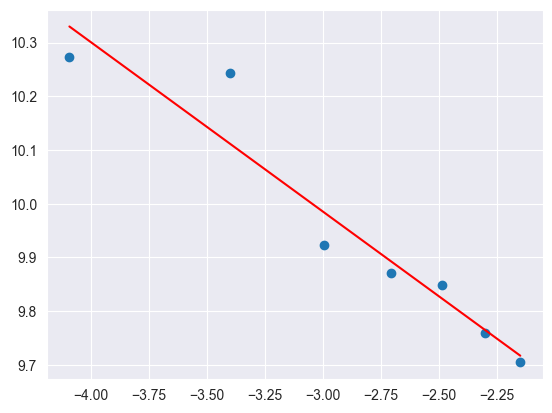

In [49]:
plt.scatter(x, y)
plt.plot(x, model.predict(x_lr), color='red')
plt.show()

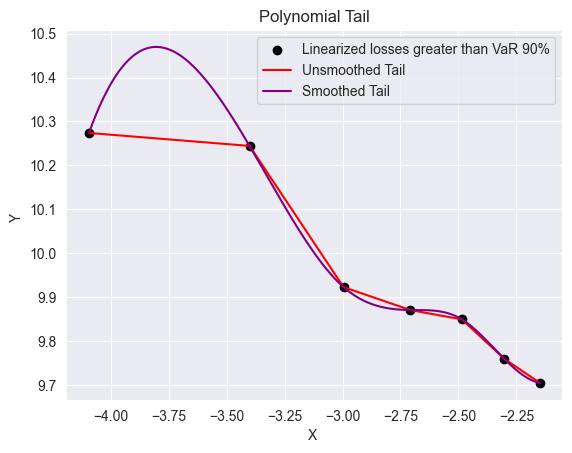

In [50]:
# interpolate the y-values using a cubic spline
from scipy.interpolate import interp1d

# create a line graph from the scatter points
plt.scatter(x,y , color='Black', label='Linearized losses greater than VaR 90%')
plt.plot(x, y , color='red', label='Unsmoothed Tail')

# add labels and a title to the graph
plt.xlabel('X')
plt.ylabel('Y')

# create a set of evenly spaced points along the x-axis
x_smooth = np.linspace(min(x), max(x), 300)
f = interp1d(x, y, kind='cubic')
y_smooth = f(x_smooth)

# create a line graph from the smoothed points
plt.plot(x_smooth, y_smooth, color='purple' , label='Smoothed Tail')

# add labels and a title to the graph
plt.xlabel('X ')
plt.ylabel('Y ')
plt.title('Polynomial Tail')
plt.legend()

# display the graph
plt.show()


In [51]:
# Assigning beta 0 and beta_1 values

beta_0 = model.intercept_
beta_1 = model.coef_[0]

In [52]:
# Calculating the Tail Coefficient (a) => Tail Index

a = -1 / beta_1
a

3.175179127823746

In [53]:
# Calculating the VaR at 95% confidence level using the Tail Index

VaR_n_95 = VaR_n_90 * ((1 - 0.9) / (1 - 0.95)) ** (1/a)
print("95% VaR norm-distribution: $", VaR_n_95)

95% VaR norm-distribution: $ 19670.201652614855


In [54]:
# Calculating Expected Shortfall for 95%

ES_n_95 = VaR_n_95 * ((a)/(a-1))
print("95% CVaR/ER: $", ES_n_95)

95% CVaR/ER: $ 28713.227765271044


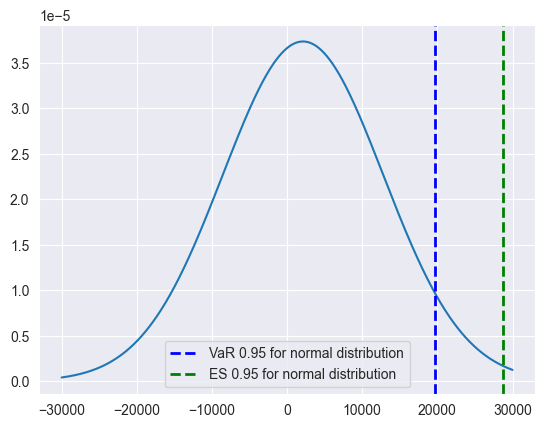

In [55]:
from scipy.stats import norm
x_axis  = np.arange(-30000,30000, 0.01)
plt.plot(x_axis, norm.pdf(x_axis,mean,std))
plt.axvline(x=VaR_n_95, color='blue', linestyle='dashed', linewidth=2, label='VaR 0.95 for normal distribution' )
plt.axvline(x=ES_n_95, color='green', linestyle='dashed', linewidth=2, label='ES 0.95 for normal distribution' )
plt.legend()
plt.show()